In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.animation import FuncAnimation
from utility import analysis_parameters as ap
import cartopy.crs as ccrs
import numpy as np
import netCDF4 as nc
import dask
# from dask.diagnostics import ProgressBar
# pbar = ProgressBar()
# pbar.register()

model='UMr1deg'
var="pr"
diff=False
chunk_dict = {"lat":100, "lon":100, "latitude":100, "longitude":100}

# instantaneous snapshot of global tropics

In [2]:
t=44
chunk_dict = {"lat":100, "lon":100, "latitude":100, "longitude":100}
ds = ap.load_iwp(model, 'GT', total=True, chunks=chunk_dict)
ds = ds.isel(time=t)*1000
ds

<xarray.DataArray 'clivi' (lat: 60, lon: 360)>
dask.array<mul, shape=(60, 360), dtype=float32, chunksize=(60, 100), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2020-01-30T11:15:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5

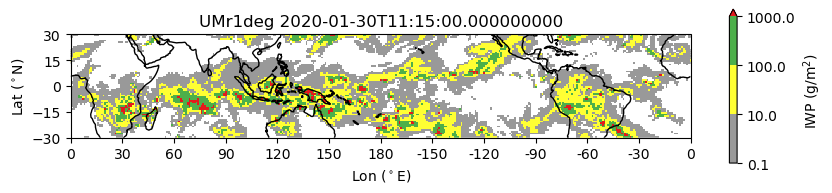

In [3]:
# snapshot
vmin=1e-1
vmax=1e3
fig = plt.figure(figsize=(10,4))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
im = ds.where(ds>0.1).plot.pcolormesh(ax=ax,
                     transform=ccrs.PlateCarree(),  
                     # cmap="ocean_r",
                     # norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),
                     cmap="Set1_r",
                     levels=[0.1,10,100,1000],
                     add_colorbar=False)
cbar = plt.colorbar(im, label="IWP (g/m$^2$)", shrink=0.5)

ax.coastlines()
ax.set(xticks=np.arange(-180,181,30), 
       xticklabels=[0,30,60,90,120,150,180,-150,-120,-90,-60,-30,0], 
       xlabel="Lon ($^\circ$E)",
       yticks=np.arange(-30,31,15),
       ylabel="Lat ($^\circ$N)",
       title=model+" "+str(ds.time.values))
plt.savefig("../plots/GT/GT_{}_snapshot-IWP-thres1e-1-10-100-1000.png".format(model),dpi=120, bbox_inches="tight")
plt.show()

In [23]:
# # animate to gif
# t=0
# vmin=1e-1
# vmax=1e3
# fig = plt.figure(figsize=(10,4))
# gs = fig.add_gridspec(1,1)
# ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
# im = ds.isel(time=t).plot.pcolormesh(ax=ax,
#                      transform=ccrs.PlateCarree(),  
#                      # cmap="ocean_r",
#                      # norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),
#                      cmap="ocean_r",
#                      levels=[0.1,10,1000],
#                      add_colorbar=False)
# cbar = plt.colorbar(im, label="IWP (g/m$^2$)", shrink=0.5)

# ax.coastlines()
# ax.set(xticks=np.arange(-180,181,30), 
#        xticklabels=[0,30,60,90,120,150,180,-150,-120,-90,-60,-30,0], 
#        xlabel="Lon ($^\circ$E)",
#        yticks=np.arange(-30,31,15),
#        ylabel="Lat ($^\circ$N)")

# def update(t):
#     ds.isel(time=t).plot.pcolormesh(ax=ax,
#                      transform=ccrs.PlateCarree(),  
#                      cmap="ocean_r",
#                      # norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),
#                      # cmap="Set2_r",
#                      levels=[0.1,10,1000],
#                      add_colorbar=False)
#     return im

# ani = FuncAnimation(fig, update, frames=100)
# ani.save("../plots/animation_GEOS_IWP_thres1e-1-10-1000.gif")
# plt.show()

# global tropical mean plot

In [2]:
# load variables into an array
mod_means = {}
if var=="rlt":
    models = ["SCREAMr1deg", "SAMr1deg", "ARPr1deg", "ICONr1deg"]
    models1= ["UMr1deg", "GEOSr1deg", "SHiELDr1deg"]
    var1="rlut"
    da = xr.open_dataset(ap.get_timmean_file("CERES","GT","rad_toa_1hm_JFM")).adj_atmos_lw_up_all_toa_1hm.mean(dim="time")
    mod = {"CERES 1HM":da}
    mod_means["CERES 1HM"] = da.mean().values
    print(da.shape)
    
    chunk_dict = {"lat":100, "lon":100, "latitude":100, "longitude":100}

    for m in models:
        print(m)
        dmod = xr.open_dataset(ap.get_timmean_file(m, "GT", var), chunks=chunk_dict)[var][0]
        if m=="ARPr0.25deg":
            dmod=-dmod/900
        mod_means[m] = dmod.mean().values
        if diff:
            dam = da.interp({"lon":dmod.lon, "lat":dmod.lat})
            das = dmod - dam.values
            mod[m] = das
        else:
            mod[m] = dmod
    for m in models1:
        print(m)
        if (m=="NICAMr1deg") or (m=="UMr1deg"):
            dmod = xr.open_dataset(ap.get_timmean_file(m, "GT", var1), chunks=chunk_dict)[var1]
        else:
            dmod = xr.open_dataset(ap.get_timmean_file(m, "GT", var1), chunks=chunk_dict)[var1][0]
        if m[:2]=="UM":
            dam = da.interp({"lon":dmod.longitude.values, "lat":dmod.latitude.values})
        else:
            dam = da.interp({"lon":dmod.lon, "lat":dmod.lat})
        mod_means[m] = dmod.mean().values
        if diff:
            das = dmod - dam.values
            mod[m] = das
        else:
            mod[m] = dmod
        
elif var=="pracc":
    print("getting accumulated precipitation over the 40 day period")
    all_models = [None, "SCREAM", "SAM", "ARP", "ICON", "UM", "GEOS", "SHiELD"]
    mod = {}
    mod_means = {}
    for m in all_models:
        if m is not None:
            mod[m] = xr.open_dataset(ap.get_timcumsum_file(m)).isel(time=0).pracc
            mod_means[m] = mod[m].sum()
            print(m, mod[m].shape)
        else:
            mod[""] = None
            
elif var=="pr":
    print("getting precipitation rates over the 40 day period")
    all_models = [None, "SCREAM", "SAM", "ARP", "ICON", "UM", "GEOS", "SHiELD"]
    mod = {}
    mod_means = {}
    for m in all_models:
        if m is not None:
            # mod[m] = xr.open_dataset(ap.get_timmean_file(m+'r1deg','GT','pr')).isel(time=0).pr*3600*24 # mm/s --> mm/day (*3600*24)
            mod[m] = xr.open_dataset(ap.get_daymean_file(m,'GT','pr')).mean(dim=['time']).pr*3600*24 # mm/s --> mm/day (*3600*24)
            
            if m=="ARP":
                mod[m] = mod[m]/1000
            elif m=="SCREAM":
                mod[m] = mod[m]*1000
            mod_means[m] = np.nanmean(mod[m])
            print(m, mod[m].shape)
        else:
            mod[""] = None
        

getting precipitation rates over the 40 day period
SCREAM (60, 360)
SAM (60, 360)
ARP (60, 360)
ICON (60, 360)
UM (60, 360)
GEOS (60, 360)
SHiELD (60, 360)


In [3]:
len(mod)//2

4

0 
1 SCREAM
... defined da...
... plotting...
... plotted. Adding axis stuff...
...done with 2 of 8
2 SAM
... defined da...
... plotting...
... plotted. Adding axis stuff...
...done with 3 of 8
3 ARP
... defined da...
... plotting...
... plotted. Adding axis stuff...
...done with 4 of 8
4 ICON
... defined da...
... plotting...
... plotted. Adding axis stuff...
...done with 5 of 8
5 UM
... defined da...
... plotting...
... plotted. Adding axis stuff...
...done with 6 of 8
6 GEOS
... defined da...
... plotting...
... plotted. Adding axis stuff...
...done with 7 of 8
7 SHiELD
... defined da...
... plotting...
... plotted. Adding axis stuff...
...done with 8 of 8


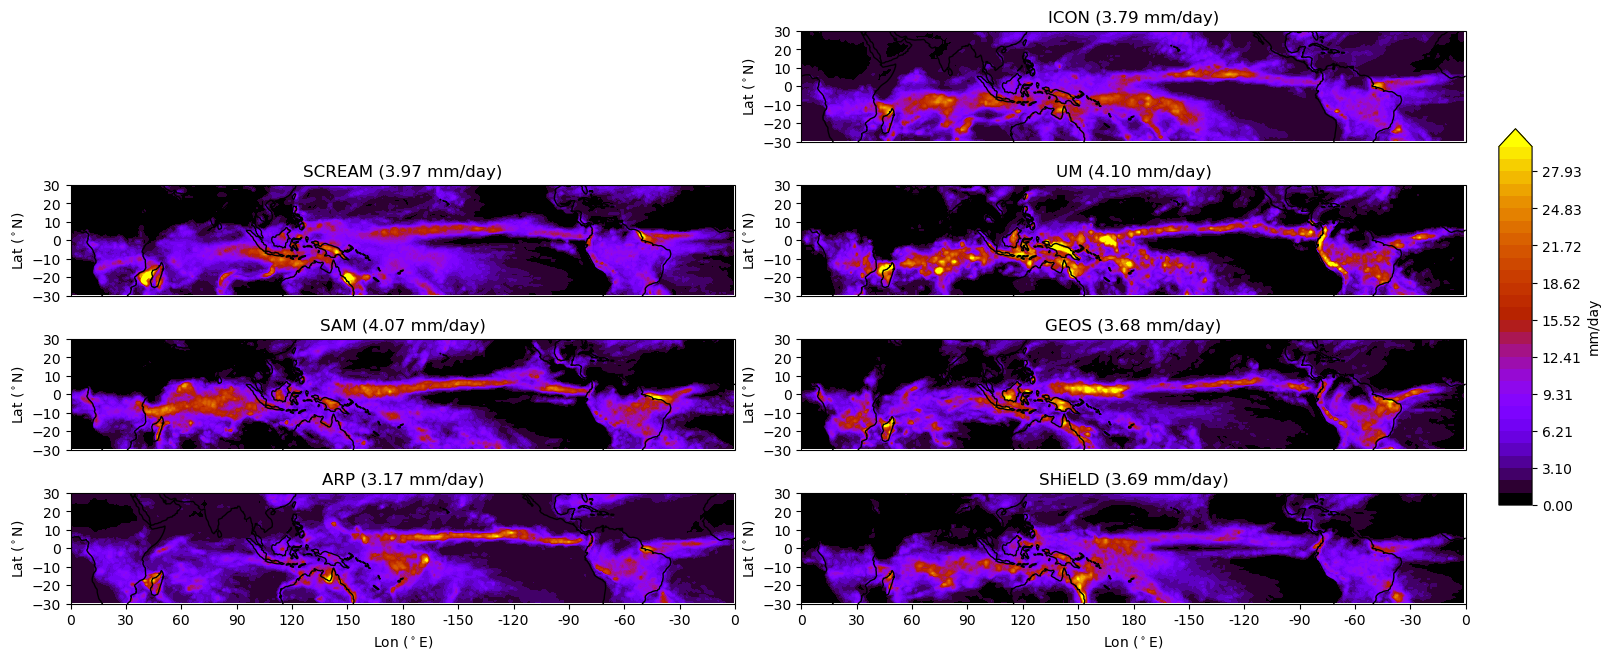

In [21]:
# fig, ax = plt.subplots(len(mod),1, figsize=(8,2*len(mod)), 
#                        subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)},
#                        sharex=True, sharey=True)
fig = plt.figure(figsize=(18,len(mod)))
gs = fig.add_gridspec(len(mod)//2,2, wspace=0.1, hspace=0.0, width_ratios=[1,1])
cmap = "YlGnBu_r"
if var=="rlt":
    omin, omax = 180, 310
    dmin, dmax = -120, 120
    lab = "OLR (W/m2)"
    ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
    im = mod["CERES 1HM"].plot(
                                ax=ax0,
                                transform=ccrs.PlateCarree(),  
                                cmap=cmap,
                                vmin=omin, vmax=omax, add_colorbar=False
                                )
    ax0.coastlines()
    ax0.set_title(m.split("r")[0])
    ax0.set_yticks(np.arange(-30,31,10))
    ax0.set_ylabel("Lat ($^\circ$N)")
    ax0.set_title("CERES 1HM ({:0.1f} W/m$^2$)".format(mod_means["CERES 1HM"]))
    ax0.set_ylim([-30,30])
    units="W/m$^2$"
elif var[:3]=="cli":
    omin, omax = 0, 0.6
    lab = "cld frac"
    units="1"
elif var=="pracc":
    omin, omax = 0, 1200
    units="mm"
    lab = "cumulative precip after 40 days"
elif var=="pr":
    omin, omax = 0, 30
    units="mm/day"
    lab = "precip rate over last 30 days"
else:
    print("what is your variable: var=",var)

   

i=0
for m in list(mod.keys()):
    print(i,m)
    if var=="cli":
        if m=="UM":
            lev="model_level_number"
        else:
            lev="lev"
    if mod[m] is not None:
        da = mod[m]
    else:
        ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
        ax0.axis('off')
        i+=1
        continue
    print("... defined da...")
    if diff:
        if m=="CERES 1HM":
            vmin=omin
            vmax=omax
            cmap = "YlGnBu_r"
        else:
            vmin, vmax = dmin, dmax
            cmap = "bwr"
    else:
        if var=="pr":
            cmap="gnuplot"
        else:
            cmap="YlGnBu_r"
        vmin=omin
        vmax=omax
    if m=="CERES 1HM":
        i+=1
        continue
    print("... plotting...")
    ax = fig.add_subplot(gs[i%(len(mod)//2),i//(len(mod)//2)], projection=ccrs.PlateCarree(central_longitude=180), sharex=ax0)

    pc = da.plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),  
        cmap=cmap,
        levels=30,
        vmin=vmin, vmax=vmax, 
        add_colorbar=False,
        # norm="log",
        # norm=mcolors.LogNorm(vmin=0, vmax=40),
        # cbar_kwargs={"orientation": "vertical", "shrink": 0.7,"label":lab},
        # robust=True
    )
    print("... plotted. Adding axis stuff...")
    ax.coastlines() 
    if var=="rlt":
        ax.set_title("{} ({:.01f} {})".format(m.split("r")[0], mod_means[m], units))
    elif var=="pracc":
        ax.set_title("{} ({:.2E} {})".format(m.split("r")[0], mod_means[m], units))
    elif var=="pr":
        ax.set_title("{} ({:.2f} {})".format(m.split("r")[0], mod_means[m], units))
    ax.set_yticks(np.arange(-30,31,10))
    # ax.set_xticks(np.arange(-180,181,30))
    ax.set_ylabel("Lat ($^\circ$N)")
    ax.set_ylim([-30,30])
    if var=="rlt":
        if i==2:
            axins2 = inset_axes(ax, # here using axis of the lowest plot
                       width="5%",  # width = 5% of parent_bbox width
                       height="340%",  # height : 340% good for a (4x4) Grid
                       loc='lower left',
                       bbox_to_anchor=(-0.18, -0.5, 1, 1),
                       bbox_transform=ax.transAxes,
                       borderpad=0,
                       )
    if i==6:
        axins6 = inset_axes(ax, # here using axis of the lowest plot
                   width="5%",  # width = 5% of parent_bbox width
                   height="340%",  # height : 340% good for a (4x4) Grid
                   loc='lower left',
                   bbox_to_anchor=(1.05, -0.5, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
    if i%(len(mod)//2)==(len(mod)//2)-1:
        ax.set_xticks(np.arange(-180,181,30))
        ax.set_xticklabels([0,30,60,90,120,150,180,-150,-120,-90,-60,-30,0],color='k')
        ax.set_xlabel("Lon ($^\circ$E)")
    i+=1
    print("...done with {} of {}".format(i,len(mod)))

if var=="rlt":
    cb = fig.colorbar(im, cax=axins2,  label=units, ticklocation="left") #extend="both",
cb = fig.colorbar(pc, cax=axins6, label=units) #extend="both", 

if diff:
    var=var+"_diff"

plt.savefig("../plots/GT/timmean_{}.png".format(var), dpi=250)
plt.show()

if diff:
    var=var.split("_")[0]

# TTL cld frac

In [ ]:
ds = xr.open_dataset("/work/bb1153/b380883/GT/timmean/timmean_GT_14-18km_SCREAMr0.25deg_ttlcldmask_20200130-20200228.nc").pfull
ds = ds.mean(dim=["time","lev"])
ds

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,12), 
                       subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)},
                       constrained_layout=True)
cmap = "YlGnBu_r"
i=0
(ds*100).plot(transform=ccrs.PlateCarree(),  
              ax=ax[i],
            cmap=cmap,
            vmin=0, vmax=2,
            cbar_kwargs={"orientation": "vertical", "shrink": 0.5,"label":"TTL cld frac (%)"},
            robust=True
    )
ax[i].coastlines() 
ax[i].set_xticks(np.arange(-180,181,30))
ax[i].set_xticklabels([0,30,60,90,120,150,180,-150,-120,-90,-60,-30,0])
ax[i].set_yticks(np.arange(-30,31,10))
ax[i].set_title(all_models[i]+" "+var)
ax[i].set_xlabel("Lon ($^\circ$E)")
ax[i].set_ylabel("Lat ($^\circ$N)")
ax[i].set_ylim([-30,30])

In [ ]:
### tropical cirrus coverage

clt = xr.open_dataset("/work/bb1153/b380883/GT/GT_SCREAMr0.1deg_clt_20200130-20200228.nc", chunks=500).clt
clt

In [ ]:
clt.mean(axis=0).plot(y="lat")
plt.show()

In [ ]:
# # compare remapdis vs remapcon with different scales

# og = xr.open_dataset("/work/bb1153/b380883/TWP/TWP_SHiELDr0.1deg_rlut_20200130-20200228.nc").rlut.sel(time=slice("2020-02-22T00:15","2020-02-23T00:00"))
# co = xr.open_dataset("/work/bb1153/b380883/TWP/SHiELD_remapcon_testr0.1deg.nc").rlut

# og.shape, co.shape

# og.time[0].values, co.time[0].values

# plt.scatter(og.values.flatten(), co.values.flatten(), label="r="+str(xr.corr(og, co).values))
# plt.plot([75,275],[75,275], color="k")
# plt.xlabel("cdo remapdis,r3600x1800")
# plt.ylabel("cdo remapcon,r3600x1800")
# plt.title("OLR SHiELD 2020-02-22 0.1 deg")
# plt.legend()
# plt.savefig("../plots/r_value_OLR_SHiELD_remapconVSremapdis.png", dpi=140)
# plt.show()


# i=2
# og = og.coarsen(lat=i, lon=i, boundary="trim").mean()
# co = xr.open_dataset("/work/bb1153/b380883/TWP/SHiELD_remapcon_testr0.2deg.nc").rlut[:,:,:50]
# co.shape, og.shape

# plt.scatter(og.values.flatten(), co.values.flatten(), label="r="+str(np.corrcoef(og.values.flatten(), co.values.flatten())[0,1]))
# plt.plot([75,275],[75,275], color="k")
# plt.xlabel("cdo remapdis,r3600x1800")
# plt.ylabel("cdo remapcon,r3600x1800")
# plt.title("OLR SHiELD 2020-02-22 0.2 deg")
# plt.legend()
# plt.savefig("../plots/r_value_OLR_SHiELD_remapconVSremapdis0.2deg.png", dpi=140)
# plt.show()

# i=10
# og = og.coarsen(lat=i, lon=i, boundary="trim").mean()
# co = xr.open_dataset("/work/bb1153/b380883/TWP/SHiELD_remapcon_testr1deg.nc").rlut[:,:,:10]
# co.shape, og.shape

# plt.figure()
# plt.scatter(og.values.flatten(), co.values.flatten(), label="r="+str(np.corrcoef(og.values.flatten(), co.values.flatten())[0,1]))
# plt.xlabel("cdo remapdis,r3600x1800")
# plt.ylabel("cdo remapcon,r3600x1800")
# plt.title("OLR SHiELD 2020-02-22 1 deg")
# plt.legend()
# plt.savefig("../plots/r_value_OLR_SHiELD_remapconVSremapdis1deg.png", dpi=140)
# plt.show()

# hovmoller plot of OLR

In [59]:
# load variables into an array
if var=="rlt":
    models = ["SCREAMr1deg", "SAMr1deg", "ARPr1deg", "ICONr1deg"]
    models1= ["UM", "GEOSr1deg", "SHiELDr1deg"]
    # da = xr.open_dataset(ap.get_mermean_file("CERES","GT","rad_toa_1hm_JFM")).adj_atmos_lw_up_all_toa_1hm.mean(dim="time")
    # mod = {"CERES 1HM":da}
    # print(da.shape)
    mod={"obs":None}
    chunk_dict = {"lat":100, "lon":100, "latitude":100, "longitude":100}

    for m in models:
        dmod = xr.open_dataset(ap.get_mermean_file(m, "GT", var), chunks=chunk_dict)[var]
        print(m, dmod.shape)
        # if m[:3]=="ARP":
        #     dmod=-dmod/900
        if m[:2]=="IC":
            dmod = -dmod.where(dmod.time.dt.hour!=0)
        mod[m] = dmod
    for m in models1:
        dmod = xr.open_dataset(ap.get_mermean_file(m, "GT", var1), chunks=chunk_dict)[var1]
        print(m, dmod.shape)
        mod[m] = dmod


SCREAMr1deg (2880, 1, 360)
SAMr1deg (2879, 1, 360)
ARPr1deg (2880, 1, 360)
ICONr1deg (2849, 1, 360)
UM (720, 1, 5120)
GEOSr1deg (2976, 1, 360)
SHiELDr1deg (2880, 1, 360)


i= 0 obs axes 0 0
i= 1 SCREAMr1deg axes 1 0
[########################################] | 100% Completed |  0.1s
i= 2 SAMr1deg axes 2 0
[########################################] | 100% Completed |  0.1s
i= 3 ARPr1deg axes 3 0
[########################################] | 100% Completed |  0.1s
i= 4 ICONr1deg axes 0 1
[########################################] | 100% Completed |  0.1s
i= 5 UM axes 1 1
[########################################] | 100% Completed |  0.2s
i= 6 GEOSr1deg axes 2 1
[########################################] | 100% Completed |  0.1s
i= 7 SHiELDr1deg axes 3 1
[########################################] | 100% Completed |  0.1s


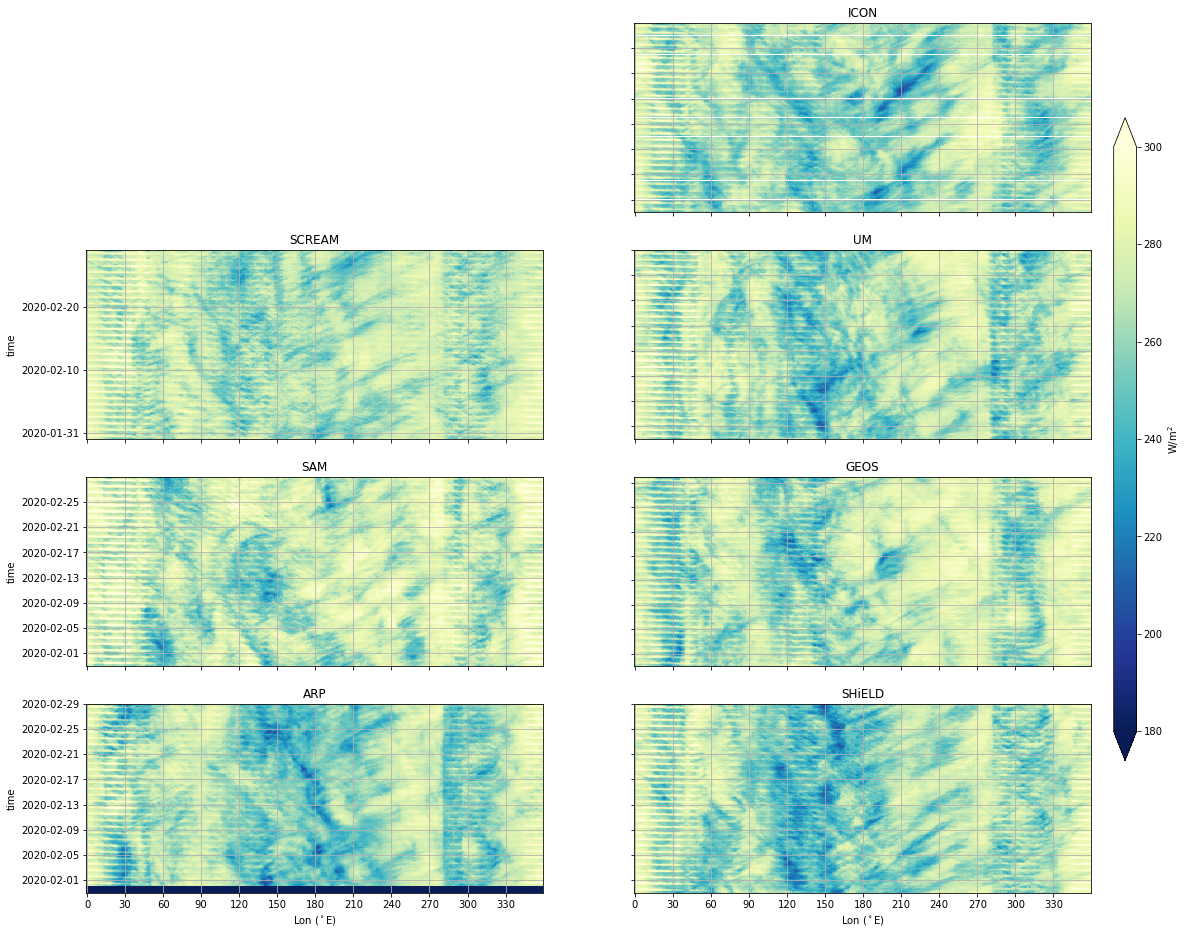

In [61]:
fig, axes = plt.subplots(4,2,figsize=(18,len(mod)*2), sharex=True, sharey=False)

cmap = "YlGnBu_r"
vmin, vmax = 180, 300
lab = "OLR (W/m2)"
for i, m in enumerate(list(mod.keys())):
    print("i=",i,m, "axes",i%4,i//4)
    ax = axes[i%4,i//4]
    da = mod[m]
    # print(da.shape, da.time[0])
    if i==0:
        ax.axis("off")
        continue
    pc = da.plot(
            y="time",
            ax=ax,
            cmap=cmap,
            vmin=vmin, vmax=vmax, 
            add_colorbar=False,
        )
    ax.set_title(m.split("r")[0])
    if i>3:
        ax.set_yticklabels([])
        ax.set_ylabel(None)
    # ax.set_ylabel("Lat ($^\circ$N)")
    # ax.set_ylim([-30,30])
    # if i==2:
    #     axins2 = inset_axes(ax, # here using axis of the lowest plot
    #                width="5%",  # width = 5% of parent_bbox width
    #                height="340%",  # height : 340% good for a (4x4) Grid
    #                loc='lower left',
    #                bbox_to_anchor=(-0.18, -0.5, 1, 1),
    #                bbox_transform=ax.transAxes,
    #                borderpad=0,
    #                )
    if i==6:
        axins6 = inset_axes(ax, # here using axis of the lowest plot
                   width="5%",  # width = 5% of parent_bbox width
                   height="340%",  # height : 340% good for a (4x4) Grid
                   loc='lower left',
                   bbox_to_anchor=(1.05, -0.5, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
    ax.set_xticks(np.arange(0,360,30))
    ax.grid(True)
    if (i%4!=3):
        ax.set_xticklabels([],color='k')
        ax.set_xlabel(None)
    else:
        ax.set_xticklabels(np.arange(0,360,30))
        ax.set_xlabel("Lon ($^\circ$E)")
    i+=1

# cb = fig.colorbar(im, cax=axins2, extend="both", label="W/m$^2$", ticklocation="left")
cb = fig.colorbar(pc, cax=axins6, extend="both", label="W/m$^2$")

plt.savefig("../plots/GT/hovmoller_{}.png".format(var), dpi=250)
plt.show()


[########################################] | 100% Completed |  0.1s


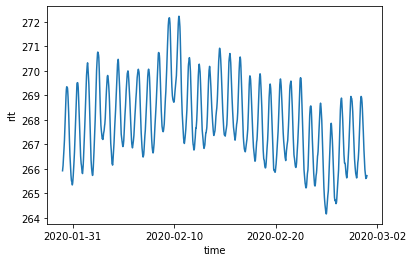

In [44]:
mod["SCREAMr1deg"].mean(axis=(1,2)).plot()

In [23]:
mod["ICONr1deg"]

<xarray.DataArray 'rlt' (time: 2849, lat: 1, lon: 360)>
dask.array<neg, shape=(2849, 1, 360), dtype=float32, chunksize=(2849, 1, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30T00:30:00 ... 2020-02-28T23:45:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 0.0
Attributes:
    standard_name:  toa_net_downward_longwave_flux_accumulated
    long_name:      Net long wave radiation flux  - accumulated _ model top
    units:          W/m2
    param:          5.5.0
    level_type:     toa
    origin:         ACCTHB_T

[########################################] | 100% Completed |  0.1s


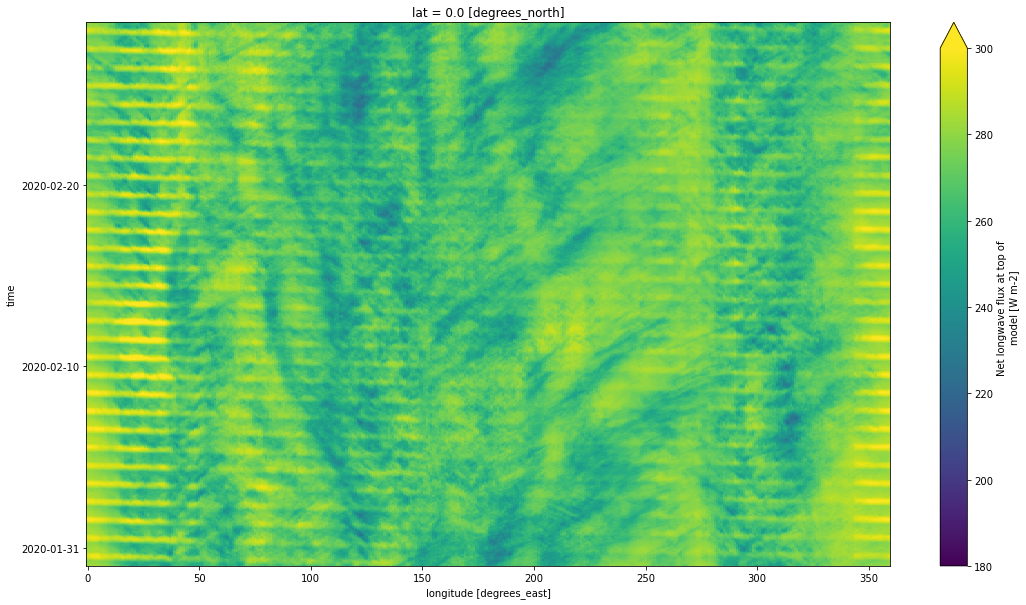

In [42]:
fig = plt.figure(figsize=(18,10))
mod["SCREAMr1deg"][:,0].plot(
# plt.pcolormesh(mod["GEOSr1deg"].lon.values, np.arange(448), mod["GEOSr1deg"][::12,0,:].values,
        vmin=180, vmax=300, add_colorbar=True
    )
plt.show()